# Lattice example for frequency allocation
Authors: Alexis Morvan

Date: September 2021

This notebook aims at show how to calculate the yield of a lattice after optimizing the smaller system with periodic boundayr condition. In order to construct both the motif and the lattice, we use the exremely good package pybinding that allow to construct lattice very easily.

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo warning
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Construction of the lattice
To construct the square lattice, we are using the pybinding lattice that allow use to imput all the edge. Luckily, pybinding lattice structure also keep the direction of the edge which will be very useful for the Cross-Resonance interaction

In [2]:
import pybinding as pb
import itertools

def chain_lattice(n):
    """ Construct a square lattice of size side n"""

    d = 1  # placeholder
    t = 1    # placeholder

    # create a simple 2D lattice with vectors a1 and a2
    lattice = pb.Lattice(a1=[n, 0])
    lattice.add_sublattices( *[(f"A_{i}", [i, 0]) for i in range(n)])

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings( *[ ([0, 0], f'A_{i}', f'A_{i+1}', t)
                           for i in range(n//2)]
    )

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings( *[ ([0, 0], f'A_{i+1}', f'A_{i}', t)
                           for i in range(n//2, n-1)]
    )


    # now the link between subregions
    lattice.add_hoppings(([1, 0], f'A_{n-1}', f'A_{0}', t)
                           
    )
    
    return lattice

import pybinding as pb
import itertools

def chain_lattice_r(n):
    """ Construct a square lattice of size side n"""

    d = 1  # placeholder
    t = 1    # placeholder

    # create a simple 2D lattice with vectors a1 and a2
    lattice = pb.Lattice(a1=[n, 0])
    lattice.add_sublattices( *[(f"A_{i}", [i, 0]) for i in range(n)])

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings( *[ ([0, 0], f'A_{2*i}', f'A_{2*i+1}', t)
                           for i in range(n//2)]
    )

    # add the hopping for the internal sub-lattice
    lattice.add_hoppings( *[ ([0, 0], f'A_{2*i}', f'A_{2*i-1}', t)
                           for i in range(1,n//2)]
    )


    # now the link between subregions
    lattice.add_hoppings(([-1, 0], f'A_{0}', f'A_{n-1}', t)
                           
    )
    
    return lattice

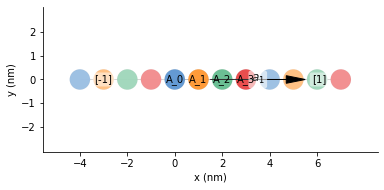

In [3]:
lattice = chain_lattice(4)

lattice.plot()  # plot the lattice that was just constructed
plt.show()      # standard matplotlib show() function


In [4]:
model = pb.Model(lattice)
hop = model.system.hoppings.tocoo()
edges = list(zip(hop.row, hop.col))
print(edges)

[(0, 1), (1, 2), (3, 2)]


## Some definition for the threshold etc...

In [5]:
architecture = "CZ"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

elif (architecture == 'CR') and qutrit:
    d_dict = {'A1': 0.017,
              'A2i': 0.03,
              'A2j': 0.03,
              'A3i': 0.03,
              'A3j': 0.03,
              "E1": 0.017,
              "E2": 0.03,
              "E3": 0.03,
              "E4":0.002,
              "F1": 0.017,
              "F2":0.025,
              "F3": 0.025,
              "M1": 0.017}
    cr_keys = ['A1', 'A2i', 'A2j','A3i', 'A3j', "E1", "E2","E3", "E4",
               "C1", "C1b", "F1", "F2","F3",  "M1"]
    cstr_key = cr_keys
    
    
# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

## Optimizing the motif model for the sqaure layout

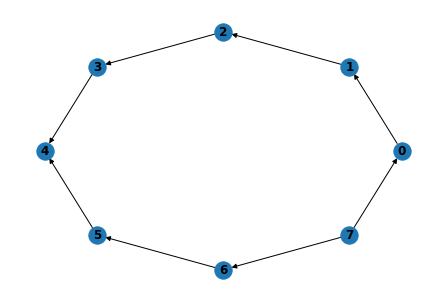

In [6]:
n = 8

lattice = chain_lattice(n)
edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D
pos = {i: [np.cos(2*np.pi*i/n), np.sin(2*np.pi*i/n)] for i in range(n)}
# define the frequency graph
G = FrequencyGraph(edges=edges, cz=cz)

# plot if needed
G.plot(pos=pos)

# In the plot, some of the interaction are actually on top of each other, making it hard to see

In [7]:
pos

{0: [1.0, 0.0],
 1: [0.7071067811865476, 0.7071067811865475],
 2: [6.123233995736766e-17, 1.0],
 3: [-0.7071067811865475, 0.7071067811865476],
 4: [-1.0, 1.2246467991473532e-16],
 5: [-0.7071067811865477, -0.7071067811865475],
 6: [-1.8369701987210297e-16, -1.0],
 7: [0.7071067811865475, -0.7071067811865477]}

In [8]:
# defining the optimizer
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             all_differents=all_differents)

# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
print("first pass done")
result = optimizer.second_pass()
print("second pass done")
result = optimizer.third_pass()
print("third pass done")

first pass done
second pass done
third pass done


True


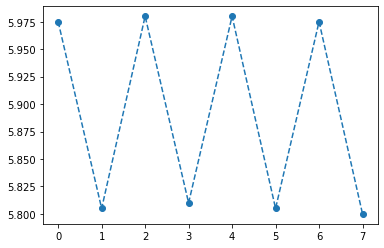

In [9]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)
print(G.check_solution(d_dict, cstr=cstr_key))
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')

Qubit collisions:
yield   = 0.72
average = 1.57


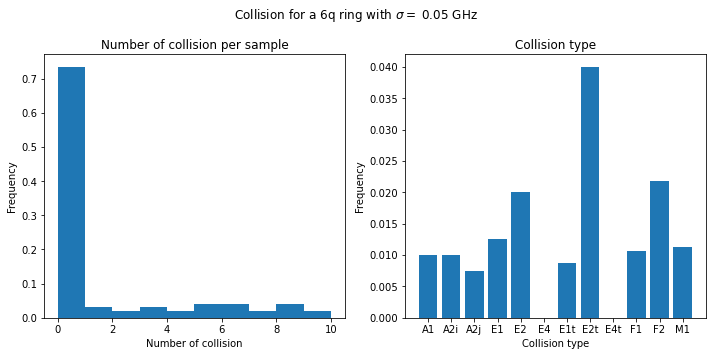

In [23]:
# parametrization
Nsamples = 100
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict,
                                                       sigma=sigma,
                                                       qutrit=qutrit,
                                                       cstr=cstr_key,
                                                       Nsamples=Nsamples,
                                                       reoptimize=True
                                                      )

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(constraints)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

Currently at 0 %
yield: 100 %
Currently at 10 %
yield: 100 %
Currently at 20 %
yield: 100 %
Currently at 30 %
yield: 100 %
Currently at 40 %
yield: 100 %
Currently at 50 %
yield: 100 %
Currently at 60 %
yield: 100 %
Currently at 70 %
yield: 99 %
Currently at 80 %
yield: 97 %
Currently at 90 %
yield: 92 %


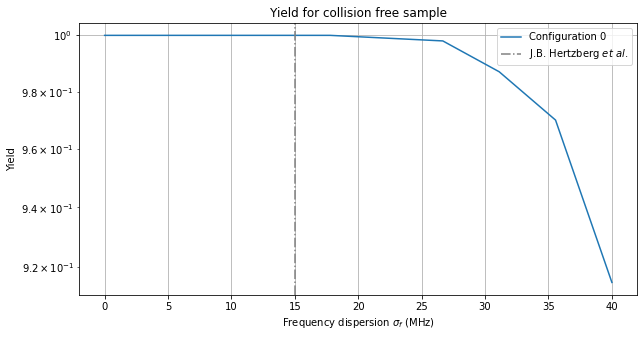

In [20]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 10000
Nsamples_b = 1000


data = []
# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.040, 10)

n_collisions = [0]

# saving the results
for k, s in enumerate(s_vec):
    print(f"Currently at {k/len(s_vec)*100:0.0f} %")
    collisions = G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key, reoptimize=False)[0]
    y = [(Nsamples-np.count_nonzero(collisions-n))/Nsamples for n in n_collisions]
    if y[0]<0.999:
        collisions = G.get_collision(d_dict, Nsamples=Nsamples_b, sigma=s, cstr=cstr_key, reoptimize=True)[0]
        y = [(Nsamples_b-np.count_nonzero(collisions-n))/Nsamples_b for n in n_collisions]
    
    data.append(y[0])
    print(f"yield: {y[0]*100:0.0f} %")
    if y[0]<1e-1:
        break

ax.plot(s_vec*1e3, data, label=f'Configuration {0}')
ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

# ax.set_xlim(0, 100)
ax.grid()

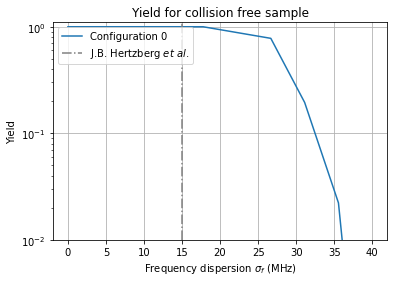

In [21]:
fig, ax = plt.subplots()

ax.plot(s_vec*1e3, np.array(data)**(1000/8), label=f'Configuration {0}')
ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_ylim(1e-2, 1.1)
# ax.set_xlim(0, 100)
ax.grid()

In [19]:
0.9999**(1000/8)

0.9875771832167982

In [11]:
collisions

array([ 0,  6, 11,  7,  5,  4, 10,  4,  3,  2,  3,  6,  4,  9, 17,  5,  2,
        2,  6, 17,  4,  0,  3,  2,  9,  5,  7,  3,  4,  0,  9,  7,  0,  5,
       10, 14,  5, 10, 10,  3,  5,  2,  2,  1,  3,  3,  6,  1,  7, 11, 10,
        5,  2,  9, 14,  2,  2,  9,  0,  0,  7,  5,  3,  0,  0,  9,  3,  5,
        5,  2,  8,  7,  2, 18,  5,  6,  1,  7,  6,  5,  4,  6,  1,  5,  1,
        8,  9,  4, 15,  6,  6,  4,  3,  2,  5,  7,  5,  0,  0,  1,  0, 13,
       10,  2, 12,  5,  0,  5,  0,  7,  1,  8,  8,  8,  1, 13,  4, 10, 12,
        5,  7,  7,  6,  2, 12,  0, 12,  7,  7,  2,  5,  5,  7,  1, 13,  9,
        1,  7, 10,  0,  9,  0,  5,  2, 12,  5,  4,  0,  3,  2,  4,  2,  3,
        1, 19,  0,  0,  8,  4,  9, 15,  6,  5,  0,  5,  9, 11, 10,  7,  9,
        3, 10,  6,  5,  4,  2,  0,  0,  5,  6,  1,  2, 14,  5, 14,  9,  5,
        7, 11,  1,  0,  2,  6,  3,  8,  1,  2,  8,  0, 10, 25,  0,  6,  1,
        5,  1,  5,  8, 10,  2,  0,  7,  6,  3,  2,  4, 11,  0,  9,  7,  4,
        0,  8, 13, 11,  4

## Scaling with Tiling

In [14]:
def rectangle(width, height):
    x0 = width / 2
    y0 = height / 2
    return pb.Polygon([[x0, y0], [x0, -y0], [-x0, -y0], [-x0, y0]])


def construct_tiling(G, model):

    freqs = {}
    anharms = {}
    drives = {}

    N = model.system.num_sites

    for node in range(N):

        # node values: frequencies and anharmonicity
        # # tge sublattice directly map to the node number of the Graph Frequency
        sublat = model.system.sublattices[node]
        freqs[node] = G.freqs[sublat]
        anharms[node] = G.anharmonicity[sublat]

    # now the edges:
    hop = model.system.hoppings.tocoo()
    edges = list(zip(hop.row, hop.col))

    for e in edges:
        e_sublat = tuple(model.system.sublattices[ee] for ee in e)
        drives[e] = G.drive[e_sublat]

    pos = {i: (model.system.x[i], model.system.y[i]) for i in range(N)}  # only taking 2D
    
    return freqs, anharms, edges, drives, pos

1000


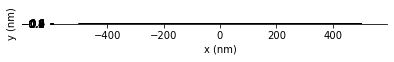

In [15]:
shape = rectangle(width=1000, height=1.5)

model = pb.Model(lattice, shape)
print(model.system.num_sites)
model.plot()
shape.plot()

In [16]:
freqs, anharms, edges, drives, pos = construct_tiling(G, model)

G2 = FrequencyGraph(edges=edges, cz=cz)
G2.set_values(freqs, anharms, drives)

The drive frequency are CR compatible


# Looping through lattice size of the cell

In [74]:
n_vec = [3, 4, 8, 12, 20]

# N_samples
Nsamples = 1e5

# varying the dispersion of the frequency
s_vec = list(np.linspace(0, 0.025, 21))
s_vec = np.array(s_vec)

data = np.zeros((len(n_vec), len(s_vec)))
window = np.zeros((len(n_vec)))

for i_n, n in enumerate(n_vec):
    
    print(f"cell size = {n}")
    
    # constructing the lattice
    lattice = chain_lattice_r(n)
    edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
    pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D

    # define the frequency graph
    G = FrequencyGraph(edges=edges, cz=cz)

    optimizer = layout_optimizer(graph=G,
                                 architecture=architecture,
                                 qutrit=qutrit,
                                 all_differents=all_differents)

    # perform the optimization
    optimizer.declare_solver()
    result = optimizer.first_pass()
    print("first pass successfull")
    optimizer.second_pass()
    print("second pass successfull")
    result = optimizer.third_pass()
    print("third pass successfull")
    
    # setting the frequencies
    freqs, anharms, drives = optimizer.get_solution()
    G.set_values(freqs, anharms, drives)
    print(G.check_solution(d_dict, cstr=cstr_key))
    
    # calculate the window
    window[i_n] = max((list(freqs.values()))) - min(list(freqs.values()))
    
    # constructing the finite size large lattice
    shape = rectangle(width=1000, height=1.5)
    model = pb.Model(lattice, shape)
    
    
    # frequency and anharmonicity are like the cell one, but with modulo
    freqs, anharms, edges, drives, pos = construct_tiling(G, model)
    print("tiling done")
    
    G2 = FrequencyGraph(edges=edges, cz=cz)
    G2.set_values(freqs, anharms, drives)
    print("graph constructed")
    
    # saving the results
    collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

    n_collisions = [0]
    y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]
    data[i_n, :] = y[0]
    print("collision done")

cell size = 3
first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 4
first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 8
first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 12
first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 20
first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True
tiling done
The drive frequency

In [21]:
from matplotlib import cm

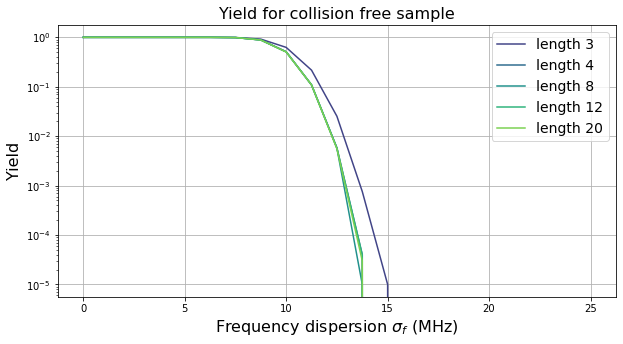

In [76]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

colors = cm.viridis(np.linspace(0.2, 0.8, len(n_vec)))

for k, (n, y) in enumerate(zip(n_vec, data)):
    ax.plot(s_vec*1e3, y, label=f'length {n}', color = colors[k])

# ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")
    
ax.set_ylabel(f'Yield', fontsize=16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
ax.set_title('Yield for collision free sample', fontsize=16)
ax.legend(ncol=1, fontsize=14, loc=0)

# ax.set_xlim(0, 100)
ax.grid()
fig.savefig("yield_square.pdf")

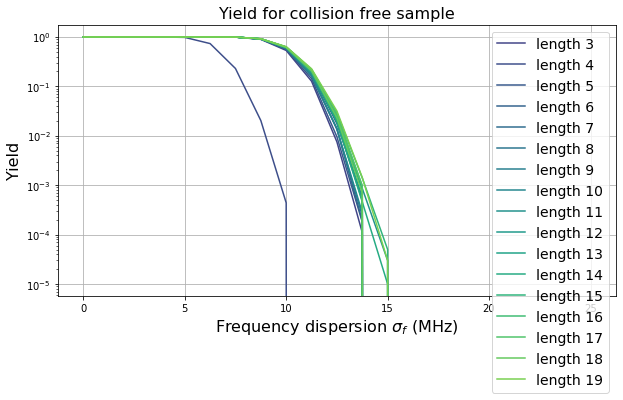

In [42]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

colors = cm.viridis(np.linspace(0.2, 0.8, len(n_vec)))

for k, (n, y) in enumerate(zip(n_vec, data)):
    ax.plot(s_vec*1e3, y, label=f'length {n}', color = colors[k])

# ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")
    
ax.set_ylabel(f'Yield', fontsize=16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
ax.set_title('Yield for collision free sample', fontsize=16)
ax.legend(ncol=1, fontsize=14, loc=0)

# ax.set_xlim(0, 100)
ax.grid()
fig.savefig("yield_square.pdf")

In [77]:
res = np.zeros(len(n_vec))
for k in range(len(n_vec)):
    res[k] = None
    for i in range(len(s_vec)):
        if np.abs(data[k, i])>9.9e-1:
            res[k] = i

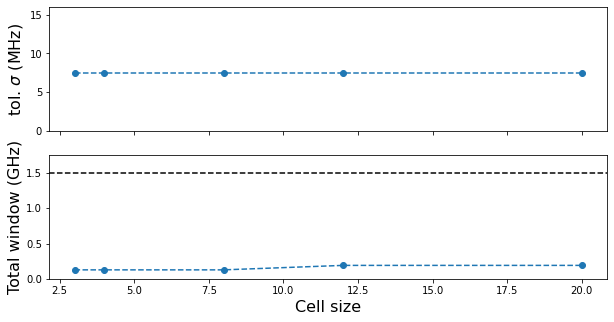

In [78]:
fig, ax = plt.subplots(2, sharex=True,  figsize=(10, 5))

ax[0].plot(n_vec, np.array([s_vec[int(r)] for r in res])*1e3, 'o--')
ax[1].plot(n_vec, window, 'o--')

ax[1].set_xlabel("Cell size", fontsize=16)
ax[0].set_ylabel("tol. $\sigma$ (MHz)", fontsize=16)
ax[1].set_ylabel("Total window (GHz)", fontsize=16)
# ax[0].set_ylim(0, 16)
ax[1].set_ylim(0, 1.75)

ax[1].axhline(1.5, color='k', ls='--')

ax[0].set_ylim(0, 16)
fig.savefig("scaling_ring.pdf")

In [79]:
np.array([s_vec[int(r)] for r in res])*1e3

array([7.5, 7.5, 7.5, 7.5, 7.5])

In [48]:
1/64

0.015625

# Qutrit yield

In [81]:
architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = True # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

elif (architecture == 'CR') and qutrit:
    d_dict = {'A1': 0.017,
              'A2i': 0.03,
              'A2j': 0.03,
              'A3i': 0.03,
              'A3j': 0.03,
              "E1": 0.017,
              "E2": 0.03,
              "E3": 0.03,
              "E4":0.002,
              "F1": 0.017,
              "F2":0.025,
              "F3": 0.025,
              "M1": 0.017}
    cr_keys = ['A1', 'A2i', 'A2j','A3i', 'A3j', "E1", "E2","E3", "E4",
               "C1", "C1b", "F1", "F2","F3",  "M1"]
    cstr_key = cr_keys
    
    
# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

In [88]:
n_vec = [3, 4]

# N_samples
Nsamples = 1e5

# varying the dispersion of the frequency
s_vec = list(np.linspace(0, 0.025, 21))
s_vec = np.array(s_vec)

data = np.zeros((len(n_vec), len(s_vec)))
window = np.zeros((len(n_vec)))

for i_n, n in enumerate(n_vec):
    
    print(f"cell size = {n}")
    
    # constructing the lattice
    lattice = chain_lattice_r(n)
    edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
    pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D

    # define the frequency graph
    G = FrequencyGraph(edges=edges, cz=cz)

    optimizer = layout_optimizer(graph=G,
                                 architecture=architecture,
                                 all_differents=all_differents)

    # perform the optimization
    optimizer.declare_solver()
    result = optimizer.first_pass()
    print("first pass successfull")
    optimizer.second_pass()
    print("second pass successfull")
    result = optimizer.third_pass()
    print("third pass successfull")
    
    # setting the frequencies
    freqs, anharms, drives = optimizer.get_solution()
    G.set_values(freqs, anharms, drives)
    print(G.check_solution(d_dict, cstr=cstr_key))
    
    # calculate the window
    window[i_n] = max((list(freqs.values()))) - min(list(freqs.values()))
    
    # constructing the finite size large lattice
    shape = rectangle(width=1000, height=1.5)
    model = pb.Model(lattice, shape)
    
    
    # frequency and anharmonicity are like the cell one, but with modulo
    freqs, anharms, edges, drives, pos = construct_tiling(G, model)
    print("tiling done")
    
    G2 = FrequencyGraph(edges=edges, cz=cz)
    G2.set_values(freqs, anharms, drives)
    print("graph constructed")
    
    # saving the results
    collisions = np.array([G2.get_collision(d_dict,
                                            Nsamples=Nsamples,
                                            qutrit=qutrit,
                                            sigma=s,
                                            cstr=cstr_key)[0] for s in s_vec])

    n_collisions = [0]
    y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]
    data[i_n, :] = y[0]
    print("collision done")

cell size = 3
first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 4
first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True
tiling done
The drive frequency are CR compatible
graph constructed
collision done


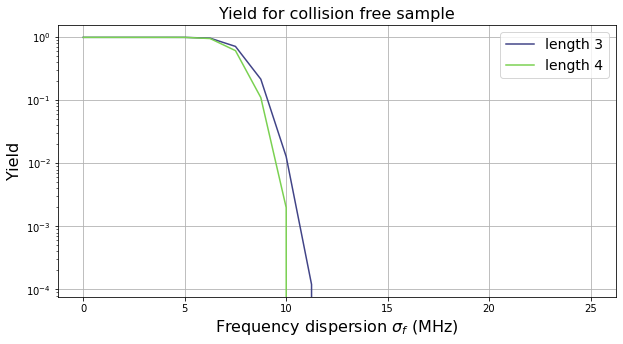

In [89]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

colors = cm.viridis(np.linspace(0.2, 0.8, len(n_vec)))

for k, (n, y) in enumerate(zip(n_vec, data)):
    ax.plot(s_vec*1e3, y, label=f'length {n}', color = colors[k])

# ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")
    
ax.set_ylabel(f'Yield', fontsize=16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
ax.set_title('Yield for collision free sample', fontsize=16)
ax.legend(ncol=1, fontsize=14, loc=0)

# ax.set_xlim(0, 100)
ax.grid()
# fig.savefig("yield_square.pdf")

In [96]:
res = np.zeros(len(n_vec))
for k in range(len(n_vec)):
    res[k] = None
    for i in range(len(s_vec)):
        if np.abs(data[k, i])>1.e-1:
            res[k] = i

In [97]:
np.array([s_vec[int(r)] for r in res])*1e3

array([8.75, 8.75])

In [87]:
G2 = FrequencyGraph(edges=edges, cz=cz)
G2.set_values(freqs, anharms, drives)
print("graph constructed")

# saving the results
collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, qutrit=qutrit, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]
data[i_n, :] = y[0]
print("collision done")

The drive frequency are CR compatible
graph constructed


KeyboardInterrupt: 

# Looking at the yield as a function of the number of transmons

In [17]:
n = 8

# constructing the lattice
lattice = chain_lattice_r(n)
edges = [(y.from_id, y.to_id) for y in lattice.hoppings['__anonymous__0'].terms]
pos = {y.unique_id: y.position[:2] for y in lattice.sublattices.values()}  # only taking 2D

# define the frequency graph
G = FrequencyGraph(edges=edges, cz=cz)

optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             qutrit=qutrit,
                             all_differents=all_differents)

# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
print("first pass successfull")
optimizer.second_pass()
print("second pass successfull")
result = optimizer.third_pass()
print("third pass successfull")

# setting the frequencies
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)
print(G.check_solution(d_dict, cstr=cstr_key))

first pass successfull
second pass successfull
third pass successfull
The drive frequency are CR compatible
True


In [19]:
N_vec = [20, 50, 100, 200, 500, 1000]

# N_samples
Nsamples = 1e5

# varying the dispersion of the frequency
s_vec = list(np.linspace(0, 0.025, 21))
s_vec = np.array(s_vec)

data = np.zeros((len(N_vec), len(s_vec)))

for i_n, N in enumerate(N_vec):
    
    print(f"cell size = {N}")
    
    # constructing the finite size large lattice
    shape = rectangle(width=N, height=1.5)
    model = pb.Model(lattice, shape)
    print(f"Lattice size = {model.system.num_sites}")
    
    # frequency and anharmonicity are like the cell one, but with modulo
    freqs, anharms, edges, drives, pos = construct_tiling(G, model)
    print("tiling done")
    
    G2 = FrequencyGraph(edges=edges, cz=cz)
    G2.set_values(freqs, anharms, drives)
    print("graph constructed")
    
    # saving the results
    collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

    n_collisions = [0]
    y = [(Nsamples-np.count_nonzero(collisions-nn, axis=1))/Nsamples for nn in n_collisions]
    data[i_n, :] = y[0]
    print("collision done")

cell size = 20
Lattice size = 20
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 50
Lattice size = 50
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 100
Lattice size = 100
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 200
Lattice size = 200
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 500
Lattice size = 500
tiling done
The drive frequency are CR compatible
graph constructed
collision done
cell size = 1000
Lattice size = 1000
tiling done
The drive frequency are CR compatible
graph constructed
collision done


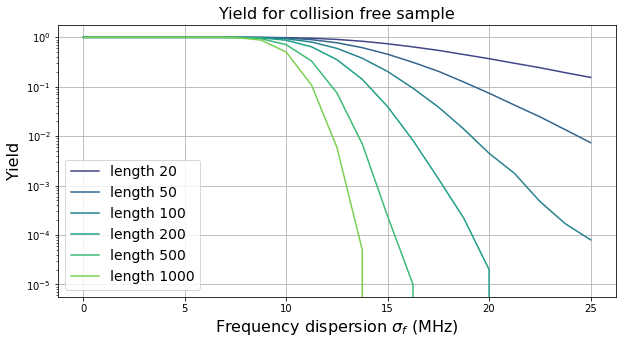

In [26]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

colors = cm.viridis(np.linspace(0.2, 0.8, len(N_vec)))

for k, (N, y) in enumerate(zip(N_vec, data)):
    ax.plot(s_vec*1e3, y, label=f'length {N}', color = colors[k])

# ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")
    
ax.set_ylabel(f'Yield', fontsize=16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
ax.set_title('Yield for collision free sample', fontsize=16)
ax.legend(ncol=1, fontsize=14, loc=0)

# ax.set_xlim(0, 100)
ax.grid()
# fig.savefig("yield_square.pdf")

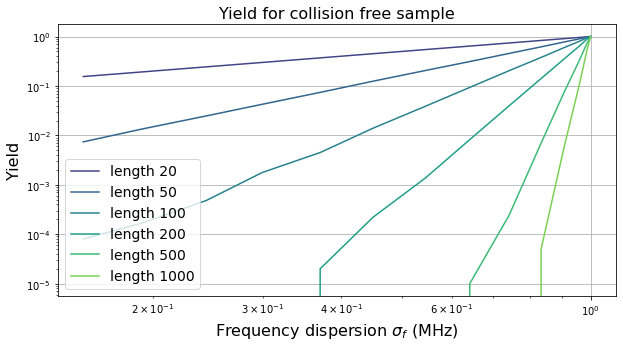

In [31]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

colors = cm.viridis(np.linspace(0.2, 0.8, len(N_vec)))

for k, (N, y) in enumerate(zip(N_vec, data)):
    ax.plot(data[0], y, label=f'length {N}', color = colors[k])

# ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
# ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")
    
ax.set_ylabel(f'Yield', fontsize=16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Yield for collision free sample', fontsize=16)
ax.legend(ncol=1, fontsize=14, loc=0)

# ax.set_xlim(0, 100)
ax.grid()
# fig.savefig("yield_square.pdf")

In [59]:
res = np.zeros(len(N_vec))
for k in range(len(N_vec)):
    res[k] = None
    for i in range(len(s_vec)):
        if np.abs(data[k, i])>1.0e-1:
            res[k] = i

<ipython-input-40-c698df812ef3>:8: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(x, 50*np.log(20)/np.log(x))


(0.0, 50.0)

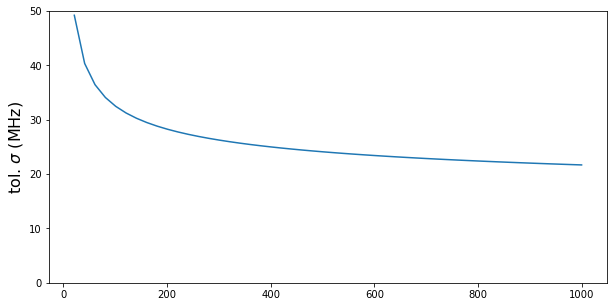

In [40]:
fig, ax = plt.subplots(  figsize=(10, 5))

# ax.plot(N_vec, np.array([s_vec[int(r)] for r in res])*1e3, 'o--')

ax.set_ylabel("tol. $\sigma$ (MHz)", fontsize=16)

x = np.linspace(1, 1000, 51)
ax.plot(x, 50*np.log(20)/np.log(x))


ax.set_ylim(0, 50)
# fig.savefig("scaling_ring.pdf")

In [70]:
N_vec

[20, 50, 100, 200, 500, 1000]